# Example: Regression with `QNNRegressor` and Variance Regularization

In this example we show how to train the `QNNRegressor` to fit a logarithm. We will also use this demonstrator to show how Variance Regularization can reduce noise and improve fit quality.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP

We will use the Pennylane quantum framework for executing the circuits.
First we train without any shots.

In [2]:
executor = Executor("pennylane", shots=None)

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

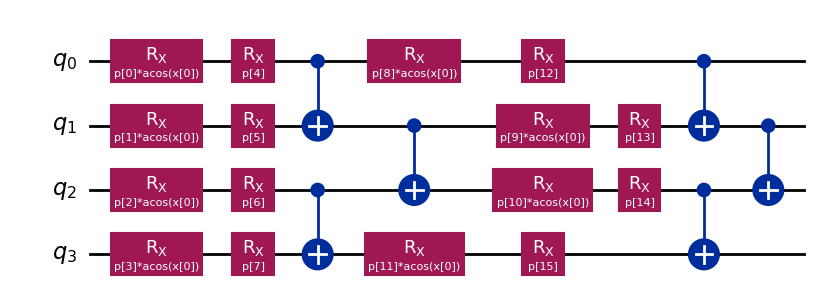

In [3]:
nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(num_qubits=nqubits, num_layers=number_of_layers)
pqc.draw("mpl", num_features=1)

We also need an observable

In [4]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

We will further specify a variance factor of $0.0005$, which will result in the models variance getting added to the loss function.

In [5]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

qnn = QNNRegressor(
    pqc,
    ising_op,
    executor,
    SquaredLoss(),
    SLSQP(),
    param_ini,
    param_op_ini,
    variance=0.0005,
)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [6]:
x_space = np.arange(0.1, 0.9, 0.1).reshape(-1, 1)
ref_values = np.log(x_space).ravel()

qnn.fit(x_space, ref_values)

fit:   0%|          | 0/100 [00:00<?, ?it/s]

fit: 100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


## Evaluation

Let's check the trained parameters of the PQC and operator

In [7]:
print("Result PQC params:", qnn.param)
print("Result operator params:", qnn.param_op)

Result PQC params: [ 0.76892475  2.94995982  2.17023765  4.62089424 -3.32070795 -2.0580005
 -0.11289467  3.00060486  3.86425918  3.28494203  3.23118623  4.62089424
 -2.83681602  1.24439607 -1.47760389 -2.05512062]
Result operator params: [-0.97711165 -0.46458806 -0.19214646]


Also let's plot the predicted function vs. the actual logarithm function

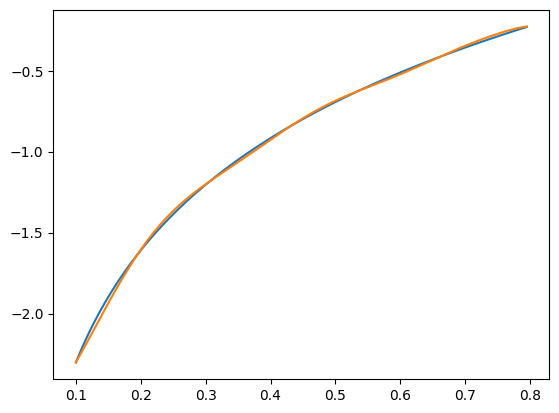

In [8]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005).reshape(-1, 1)
y = qnn.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

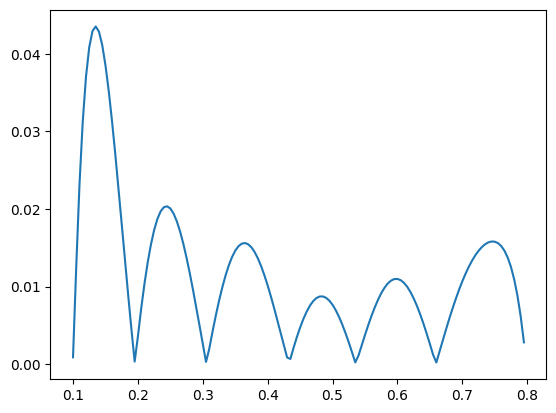

In [9]:
plt.plot(x, np.abs(y - np.log(x).ravel()))

## Evaluation on noisy simulator

Finally let's evaluate the trained `QNNRegressor` with finite sampling noise.

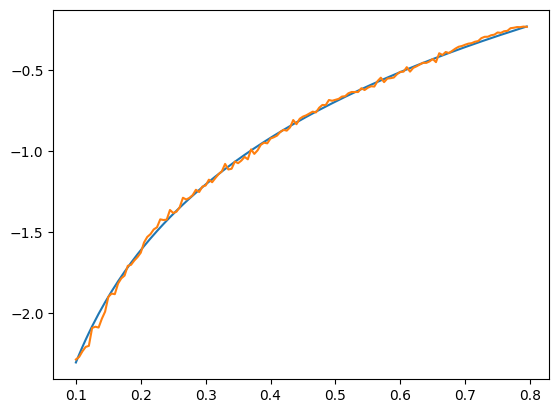

In [10]:
executor.set_shots(4000)
y = qnn.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

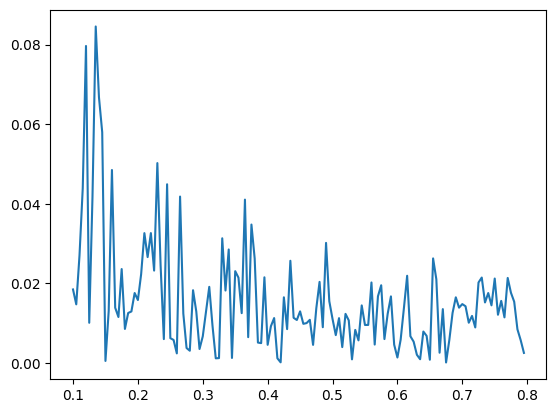

In [11]:
plt.plot(x, np.abs(y - np.log(x).ravel()))

We can see that the model is subject to less noise, than without variance regularization.